In [2]:
# import packages
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn import metrics
from PIL import Image
from tqdm.notebook import tqdm
import pickle

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet101

In [3]:
# set random seed
import random
random.seed(33)
np.random.seed(33)

### Create a dataset loader

In [4]:
class KITTIObjectDataset(torch.utils.data.Dataset):

    def __init__(self, dataroot, 
                       mode='training', 
                       transform_fn = transforms.Compose([
                                        transforms.Resize((384, 384)), 
                                        transforms.ToTensor(),
                                        transforms.Normalize(0.5, 0.5),
                                      ]),
                       verbose=True):
        """
        Args:
            dataroot (string): Root Directory of KITTI object dataset.
        """
        # paths
        self.dataroot = dataroot
        self.transform_fn = transform_fn
        self.train_dir = os.path.join(dataroot, mode)
        self.left_image_dir = os.path.join(self.train_dir, 'image_2')
        # filenames
        self.left_image_filenames = []
        # list files
        img_fnames_list = sorted(os.listdir(self.left_image_dir))
        if verbose: print('Loading Dataset...')

        # go through each files
        for img_fname in img_fnames_list:
            fname, file_ext = os.path.splitext(img_fname)
            
            # construct filenames
            left_image_full_path = os.path.join(self.left_image_dir, img_fname)

            # check if files exist
            if os.path.exists(left_image_full_path):
                # append to list
                self.left_image_filenames.append(left_image_full_path)
            
        # print info
        print('Number of data samples in the {} set: {}'.format(mode, len(self.left_image_filenames)))

    # method to get length of data
    def __len__(self):
        return len(self.left_image_filenames)

    # method to get a sample
    def __getitem__(self, idx):
        # get image
        left_image_full_path = self.left_image_filenames[idx]
        left_image = Image.open(left_image_full_path).convert('RGB')
        # transform image
        left_image = self.transform_fn(left_image)
        # get file id
        fname, file_ext = os.path.splitext(os.path.basename(left_image_full_path))
        file_id = fname.split('.')[0]
        # return image
        return {'image': left_image, 'file_id': file_id}

### Define paths and dataset

In [5]:
dataset_path = '/floppy/datasets/KITTI/object'
dataset = KITTIObjectDataset(dataset_path, mode='training')
dataset_str = 'kitti'

Loading Dataset...
Number of data samples in the training set: 7481


In [6]:
train_features_fname = f'{dataset_str}_training_features.pkl'
train_cluster_info_fname = f'{dataset_str}_training_cluster_info.pkl'

### Compute features from raw dataset

In [7]:
if not os.path.exists(train_features_fname):
    
    # use a pre-trained model to get the feature vectors for all the images
    # in the dataset
    model = resnet101(pretrained=True, progress=True)
    # remove the last layer keeping the weights
    model = torch.nn.Sequential(*list(model.children())[:-1])

    model.eval()
    model.cuda()
    train_ids, train_features = [], []
    with torch.no_grad():
        for i in tqdm(range(len(dataset))):
            img = dataset[i]['image'].unsqueeze(0).cuda()
            # inference
            feature = model(img).flatten().cpu().numpy()
            train_features.append(feature)
            train_ids.append(dataset[i]['file_id'])
    train_features = np.array(train_features)
    # save the features to disk as a pickle file
    with open(train_features_fname, 'wb') as f:
        pickle.dump({'ids': train_ids, 'features': train_features}, f)

### Compute clusters in a lower-dimensional space for training dataset

Projecting training dataset features to 2D...
Number of clusters: 136


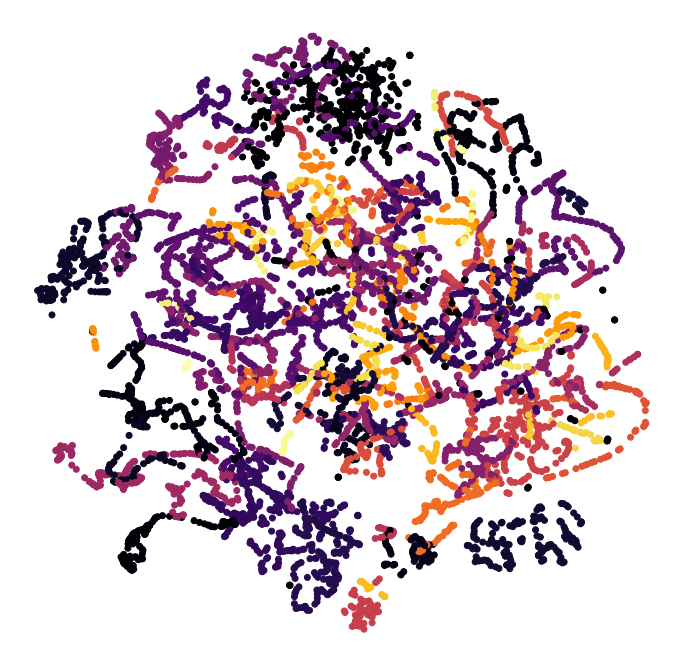

In [8]:
# load the training features from disk
data = pickle.load(open(train_features_fname, 'rb'))
train_ids, train_features = \
    data['ids'], data['features']

# project the features onto a 2D t-SNE plot
print('Projecting training dataset features to 2D...')
tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(train_features)
# find clusters using DBSCAN
db = DBSCAN(eps=2.0, min_samples=10).fit(tsne_results)
print('Number of clusters: {}'.format(len(np.unique(db.labels_))))
labels = db.labels_

# visualize the clusters
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c=labels, cmap='inferno')
ax.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap='inferno')
plt.axis('off')
plt.savefig(f'plots/{dataset_str}_training_clusters.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [9]:
# sort clusters in the order of most common to rare
unique_cluster_ids = np.unique(labels)
cluster_sizes = {cl_id: np.sum(labels == cl_id) for cl_id in unique_cluster_ids}
unique_cluster_ids = sorted(unique_cluster_ids, key=lambda i: cluster_sizes[i])
largest_cluster_size = cluster_sizes[unique_cluster_ids[-1]]

In [10]:
# get the cluster id and cluster size for each image
train_dataset_cluster_info = {}
for i in range(len(train_ids)):
    cluster_info = {'cluster_id': labels[i], 
                    'cluster_size': np.sum(labels == labels[i]),
                    'largest_cluster_size': largest_cluster_size}
    train_dataset_cluster_info[train_ids[i]] = cluster_info
# save the cluster info to disk
with open(train_cluster_info_fname, 'wb') as f:
    pickle.dump(train_dataset_cluster_info, f)
    print('Saved training cluster info to {}'.format(train_cluster_info_fname))
    

Saved training cluster info to kitti_training_cluster_info.pkl


In [11]:
# load cluster info from disk
train_dataset_cluster_info = pickle.load(open(train_cluster_info_fname, 'rb'))

### Show stats about clusters

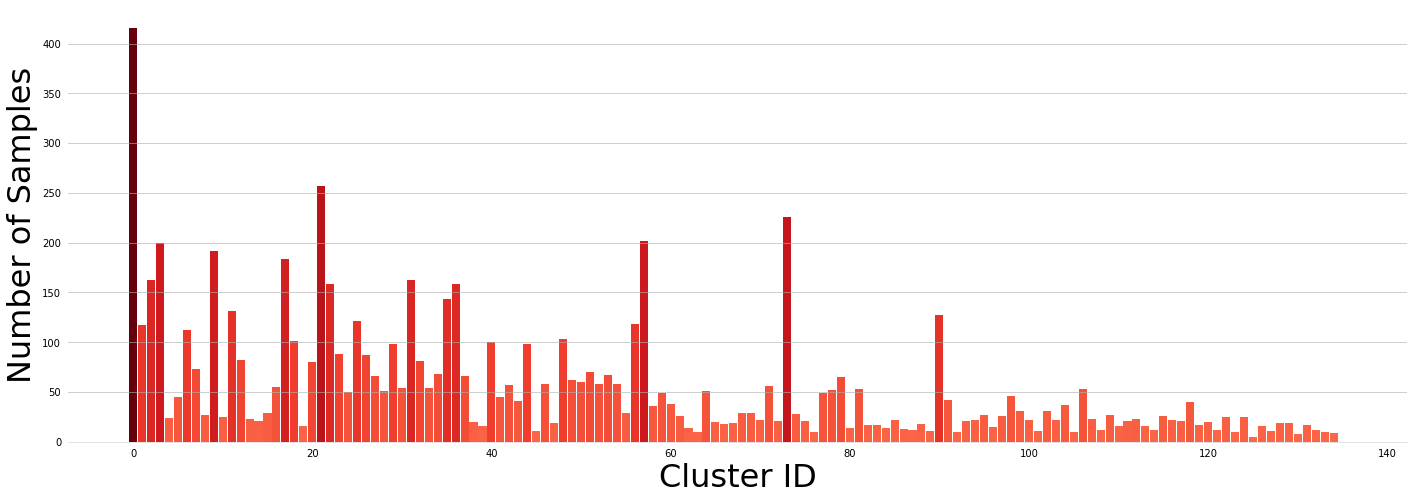

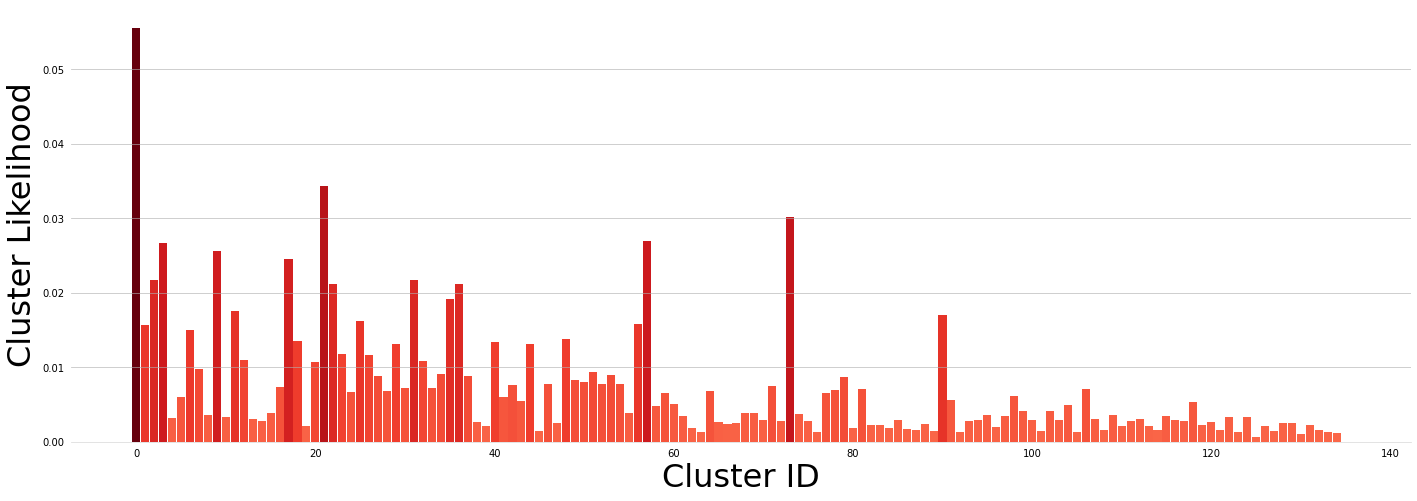

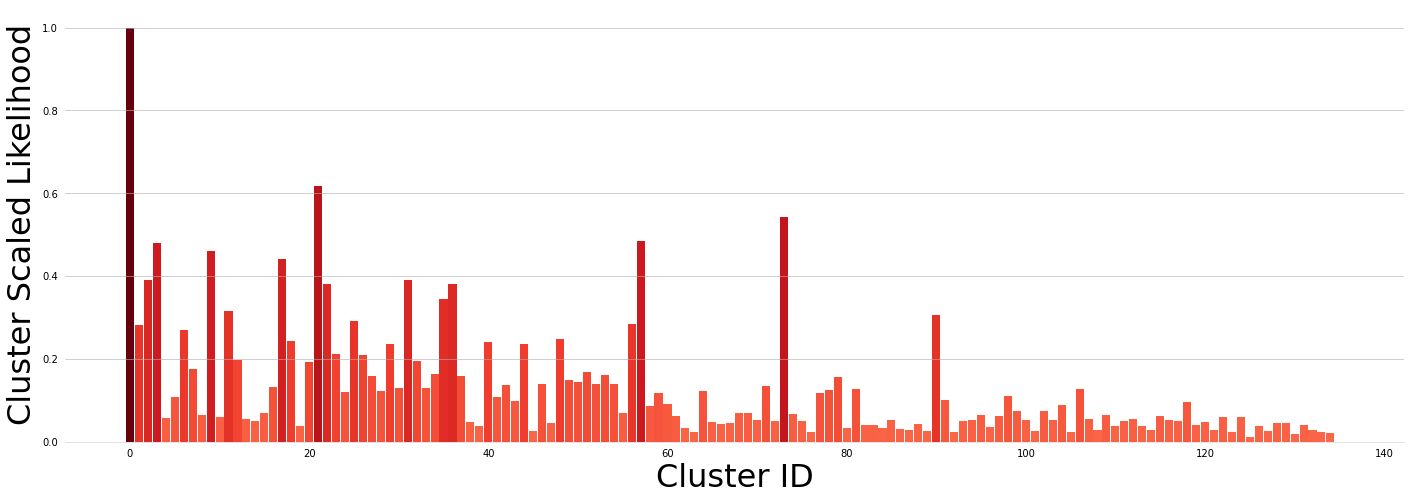

In [19]:
id_list, n_samples, sample_likelihood, sample_scaled_likelihood = \
    [], [], [], []
for i in range(len(np.unique(labels))):
    cluster_ids = np.array(train_ids)[labels == i]
    id_list.append(i)
    n_samples.append(len(cluster_ids))
    sample_likelihood.append(len(cluster_ids) / len(dataset))
    sample_scaled_likelihood.append(len(cluster_ids) / largest_cluster_size)


# plot histogram
fig, ax = plt.subplots(figsize=(24, 8))
# color each bar based on its height and color as hue of red
colors = plt.cm.Reds(0.5 + np.array(n_samples) / (2 * np.max(n_samples)))
ax.bar(id_list, n_samples, width = 0.9, color=colors)
ax.grid(axis='y', alpha=0.75)

ax.set_xlabel('Cluster ID', fontsize=32)
ax.set_ylabel('Number of Samples', fontsize=32)

# let's remove the top, right and left spines (figure borders)
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# remove the ticks as well.
ax.tick_params(bottom=False, left=False)
plt.show()

# plot cluster sample likelihood
fig, ax = plt.subplots(figsize=(24, 8))
# color each bar based on its height and color as hue of red
colors = plt.cm.Reds(0.5 + np.array(sample_likelihood) / (2 * np.max(sample_likelihood)))
ax.bar(id_list, sample_likelihood, width = 0.9, color=colors)
ax.grid(axis='y', alpha=0.75)

ax.set_xlabel('Cluster ID', fontsize=32)
ax.set_ylabel('Cluster Likelihood', fontsize=32)

# let's remove the top, right and left spines (figure borders)
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# remove the ticks as well.
ax.tick_params(bottom=False, left=False)
plt.show()

# plot cluster sample likelihood
fig, ax = plt.subplots(figsize=(24, 8))
# color each bar based on its height and color as hue of red
colors = plt.cm.Reds(0.5 + np.array(sample_scaled_likelihood) / (2 * np.max(sample_scaled_likelihood)))
ax.bar(id_list, sample_scaled_likelihood, width = 0.9, color=colors)
ax.grid(axis='y', alpha=0.75)

ax.set_xlabel('Cluster ID', fontsize=32)
ax.set_ylabel('Cluster Scaled Likelihood', fontsize=32)

# let's remove the top, right and left spines (figure borders)
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# remove the ticks as well.
ax.tick_params(bottom=False, left=False)
plt.savefig(f'plots/{dataset_str}_dataset_likelihood.png')
plt.show()

### Show a few images from each cluster

Visualizing rarest clusters of dataset samples...


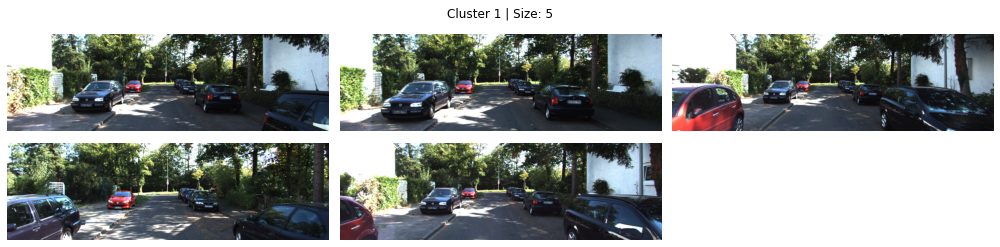

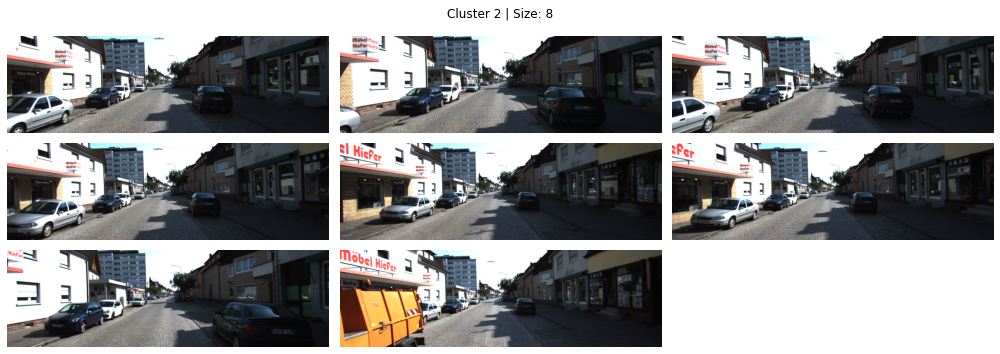

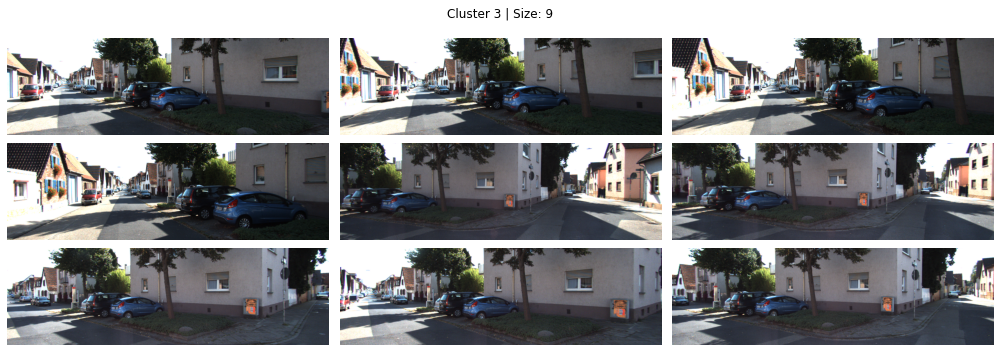

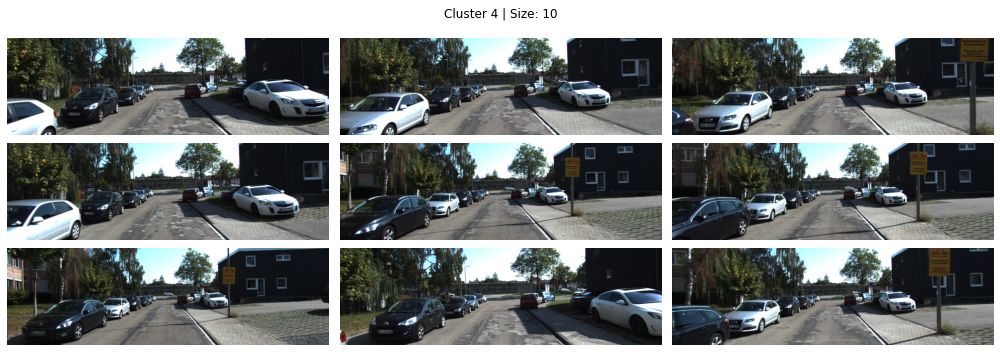

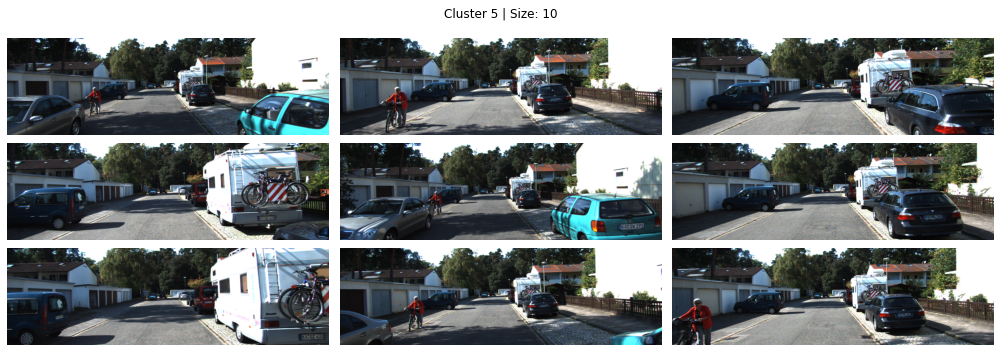

Visualizing most likely clusters of dataset samples...


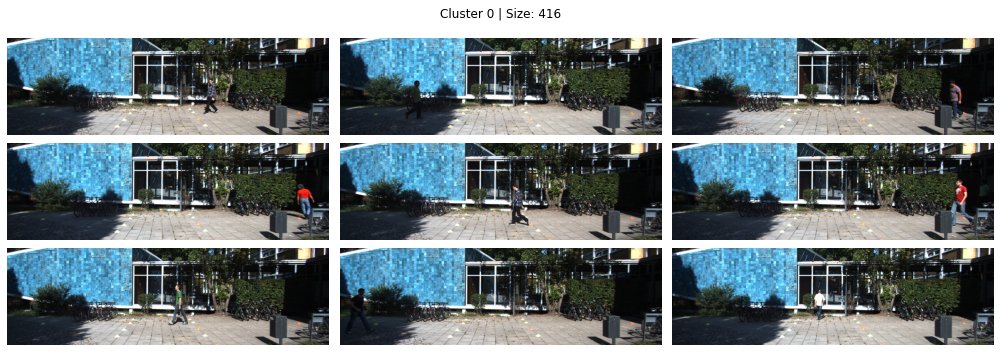

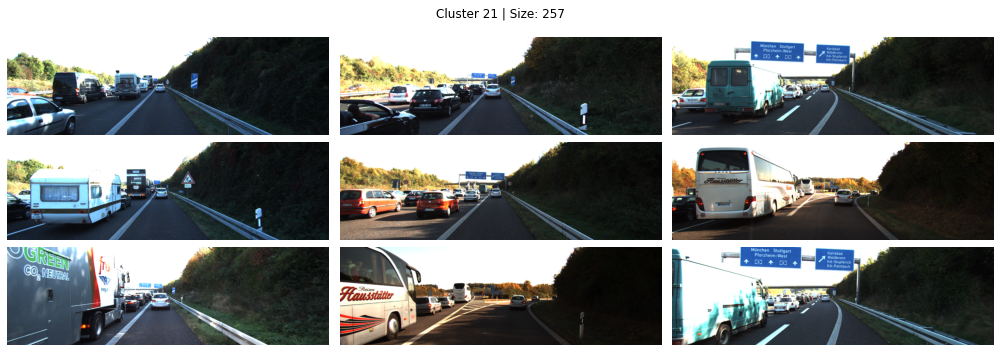

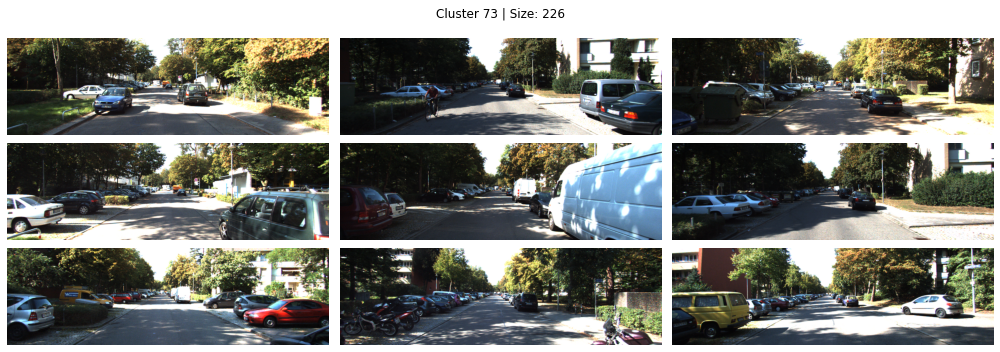

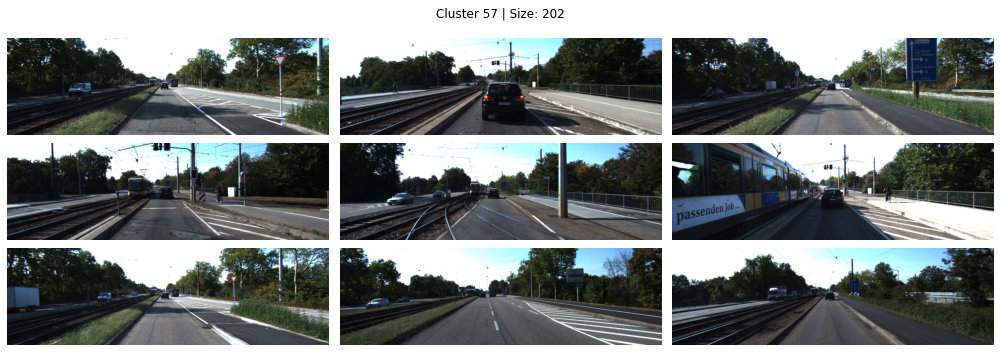

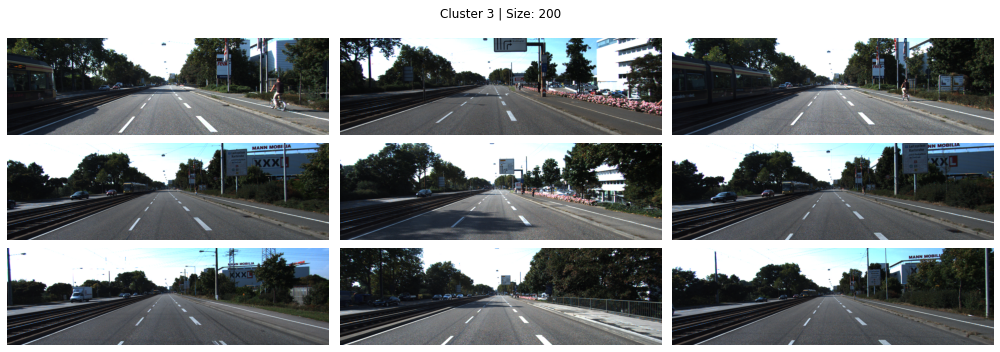

In [13]:
# show images from rarest clusters
n_clusters_to_visualize = 5
print('Visualizing rarest clusters of dataset samples...')
for i in range(min(n_clusters_to_visualize, len(unique_cluster_ids))):
    cluster_ids = np.array(train_ids)[labels == unique_cluster_ids[i]]
    # randomize the order of the images
    np.random.shuffle(cluster_ids)
    # show 9 images for this cluster
    plt.figure(figsize=(14,5))
    plt.suptitle('Cluster {} | Size: {}'.format(
        i+1, train_dataset_cluster_info[cluster_ids[0]]['cluster_size']))
    for j in range(min(9, len(cluster_ids))):
        filename = '{}/training/image_2/{}.png'.format(dataset_path, cluster_ids[j])
        
        img = Image.open(filename)
        plt.subplot(3,3,j+1)
        plt.imshow(img)

        plt.axis('off')
    plt.tight_layout()
plt.show()

# show images from most likely clusters
n_clusters_to_visualize = 5
print('Visualizing most likely clusters of dataset samples...')
reversed_unique_cluster_ids = list(reversed(unique_cluster_ids))
for i in range(min(n_clusters_to_visualize, len(reversed_unique_cluster_ids))):
    cluster_ids = np.array(train_ids)[labels == reversed_unique_cluster_ids[i]]
    # randomize the order of the images
    np.random.shuffle(cluster_ids)
    # show 9 images for this cluster
    plt.figure(figsize=(14,5))
    plt.suptitle('Cluster {} | Size: {}'.format(
        train_dataset_cluster_info[cluster_ids[j]]['cluster_id'], 
        train_dataset_cluster_info[cluster_ids[0]]['cluster_size']))
    for j in range(min(9, len(cluster_ids))):
        filename = '{}/training/image_2/{}.png'.format(dataset_path, cluster_ids[j])
        
        img = Image.open(filename)
        plt.subplot(3,3,j+1)
        plt.imshow(img)

        plt.axis('off')
    plt.tight_layout()
plt.show()